## Regression Mini Lab

In this short lab we will highlight the importance of dealing with outliers prior to fitting data.

In [1]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.stats

%matplotlib inline

## Generate the "data"

The values of our input are randomly sampled from an exponentiated weibull distribution, which is often used for failure analysis, but also describes long-tailed populations.

The values we are trying to predict are generated by transforming the inputs using a 2nd order polynomial, and injecting some normally distributed noise.

In [2]:
def gen_func(x, coefs=[400, 10, 5], noise=0.):
    y = np.zeros(len(x))
    for idx, c in enumerate(coefs):
        y += c*np.power(x, idx)
    y += scipy.stats.norm.rvs(size=len(x), random_state=2)*noise
    return y


n = 1000
f_train = 0.9
a = 1.9
c = 0.9
x = scipy.stats.exponweib.rvs(a, c, size=n, random_state=3)
y = gen_func(x, noise=20)

## Generate the "outliers"

To simulate outliers in our dataset, we will inject a small number of zero-valued entries. For the purposes of this exercise, we will assume that the outliers affect only the training data, which can happen when historical logs get corrupted.

In [3]:
n_outlier = 20
x_outlier = 4 + np.random.random(size=n_outlier)*2
y_outlier = np.zeros(len(x_outlier))

## Fit a regression

Now, let's split the data into a training and testing dataset using a 90/10 split. We will use a linear regression with polynomial terms to predict the values and the mean-squared error to evaluate the quality of the fit.

 0 outliers: Fit R^2 = 0.86, prediction MSE =  329
10 outliers: Fit R^2 = 0.27, prediction MSE = 1107
20 outliers: Fit R^2 = 0.15, prediction MSE = 2277


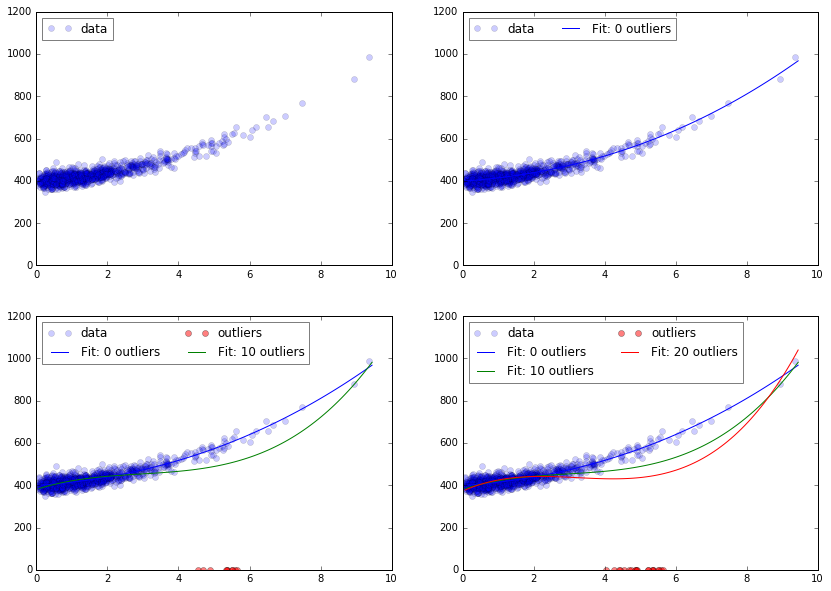

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Split the data into a training and testing set
n_train = int(f_train*n)
x_train = x[:n_train]
y_train = y[:n_train]
x_test = x[n_train:]
y_test = y[n_train:]

# create a smooth set of inputs so we can plot the prediction curve
x_grid = np.linspace(scipy.stats.exponweib.ppf(0.01, a, c),
                 scipy.stats.exponweib.ppf(0.999, a, c), 100)

fig, axs = plt.subplots(2, 2, figsize=(14,10))
axs = np.ravel(axs)

# Set the order of the polynomial fit
n_poly=4

for ax in axs:
    ax.plot(x_train, y_train, 'bo', alpha=0.2, label='data')

# Fit the data with increasing numbers of ouliters
for idx, n_outliers in enumerate((0, n_outlier/2, n_outlier)):
    if n_outliers > 0:
        ax = axs[idx+1]
        ax.plot(x_outlier[:n_outliers], y_outlier[:n_outliers], 'ro', alpha=0.5, label='outliers')

    # Inject the outliers into the training data
    x_tmp = np.concatenate([x_train, x_outlier[:n_outliers]])
    y_tmp = np.concatenate([y_train, y_outlier[:n_outliers]])

    # Transform the inputs into a n_poly order polynomial
    poly_train = np.array([np.power(x_tmp, i) for i in range(1, n_poly)]).T
    poly_test = np.array([np.power(x_test, i) for i in range(1, n_poly)]).T
    poly_grid = np.array([np.power(x_grid, i) for i in range(1, n_poly)]).T

    # Fit and evaluate the regression
    clf = LinearRegression()
    clf.fit(poly_train, y_tmp)
    fit_r2 = clf.score(poly_train, y_tmp)
    y_pred = clf.predict(poly_test)
    mse_pred = mean_squared_error(y_test, y_pred)
    
    print '%2d outliers: Fit R^2 = %.2f, prediction MSE = %4d' % (n_outliers, fit_r2, mse_pred)

    for ax in axs[idx+1:]:
        y_pred = clf.predict(poly_grid)
        ax.plot(x_grid, y_pred, '-', label='Fit: %d outliers' % n_outliers)

for ax in axs:
    ax.set_ylim(0, 1200)
    ax.legend(loc='upper left', ncol=2, framealpha=0.5)

## Open Questions

* How does the presence of outliers in the training data affect the quality of the fit?
* How could we have detected the degredation of the fit quality during the training?
* How is the fit quality affected if we substitute invalid values with the mean, median, or remove them entirely?